# PyTorch CIFAR-10 categorisation project

1. Explore the data
1. Create a baseline to judge results against
1. Implement a neural network
1. Implement improvements
1. Evaluate different parameters

## 1. Explore the data

In [16]:
import torch
from torch import cuda
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import random

#set random seed for diff sources of randomness
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
rng = np.random.default_rng(seed=0)

In [17]:
data_folder = r"../data"

transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor()])
CIFAR_data = CIFAR10(data_folder, train=True, transform=transform, download=True)

train_dataloader = DataLoader(CIFAR_data,
                          batch_size=4,
                          shuffle=True)

CIFAR_test_data = CIFAR10(data_folder, train=False, transform=transform)

test_dataloader = DataLoader(CIFAR_test_data,
                              batch_size=4,
                              shuffle=True)

Files already downloaded and verified


### Visualise data

The next cell creates train_X, train_y type data which we use to visualise the data and run our benchmark categorisation. The training of Neural Nets uses PyTorch dataloaders and not the objects created in cell below.

To help with initial data exploration, convert the entire data training set to 
tensors.

In [18]:
# to do that explicitly below. Images in DataLoader objects have pixel values
# in (0,1). The CIFAR_data.data has int values in (0,255) so have to convert
# to floats to take mean etc further down
train_imgs = torch.tensor(CIFAR_data.data).float()/255
train_y = torch.tensor(CIFAR_data.targets)
test_imgs = torch.tensor(CIFAR_test_data.data).float()/255
test_y = torch.tensor(CIFAR_test_data.targets)

classes = CIFAR_data.classes

# We need a map to get from index to class name.
# So need to reverse .class_to_idx dict:
labels_map = {}
for key, val in CIFAR_data.class_to_idx.items():
    labels_map[val] = key

Plot random sample of the data:

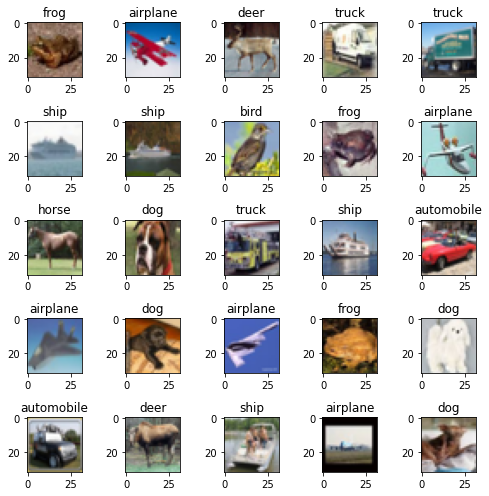

In [19]:
fig, axs = plt.subplots(5,5,figsize=(7,7))

for ax in axs.flatten():
    i = torch.randint(50000, (1,1)).item()
    ax.imshow(train_imgs[i])
    ax.set_title(labels_map[train_y[i].item()])
plt.tight_layout()

## Prepare data for benchmark categorisation

We create the training and validation data and labels.

The data is reshaped to a 4-dimensional tensor. dim 0 corresponds to list of images dim 1 is "depth" - so 3 layers for RGB; dim 2 and 3 are for the 32 pixels height and width of the images. 

We didvide pixel values by 255 so that PyTorch can work with floating point numbers in (0,1).

In [20]:
test_y.shape, test_imgs.shape, train_y.shape, train_imgs.shape

(torch.Size([10000]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([50000, 32, 32, 3]))

## Create a benchmark to judge neural net results against

Will an accuracy of above 10% imply that our neural net is doing better than chance and therefore doing a good job? Maybe.

To create a benchmark, we do a very simple prediction: we calculate the value of the "average" pixel for all the images in each category. Then for each image, we 

First create a benchmark to measure results of training neural net on.

We calculate the average RGB value for each pixel for each category. Then calculate the distance of an image form the average image for each category. Shortest distance is classified as that image. Can we do better than 10% accuracy??

In [21]:
avg_img = torch.zeros((10,32,32,3))
for i in np.arange(10):
    mask = train_y == i
    avg_img[i] = train_imgs[mask].mean(0)
    

Display our "average images". Kinda cool! The automobile and truck look like vehicles coming through the mist and the colours look different for different categories. There will be a lot of confusion between wild animals and cars/trucks for example, but the prediction based on distance from mean image should be quite good.

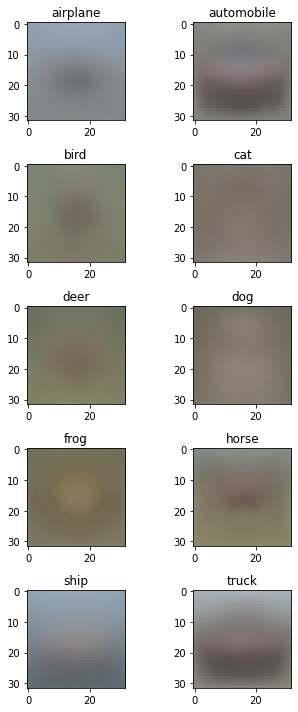

In [22]:
fig, axs = plt.subplots(5,2,figsize=(5,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_img[i])
    ax.set_title(labels_map[i])
plt.tight_layout()

Test our benchmark prediction. 28%!! Pretty good for just calculating an average. We now need our neural net to outperform 28% accuracy to be any good.

In [23]:
def cifar_distance(a,b): return ((a-b)**2).abs().mean((-1,-2,-3))
def predictions(a): return torch.argmin(a, dim=1)

preds = predictions(cifar_distance(test_imgs[:,None], avg_img[None]))
accuracy = (preds == test_y).sum()/test_imgs.shape[0]
accuracy

tensor(0.2774)

Just for curiousity, let's plot the confusion matrix. Some parts are as we expect from out crude method: it gets confused between deer and frogs (green backgrounds?) and birds and planes (sky?). 

Finally, there were 1000 of each category in the 10,000 test data set. However, our simple rule predicted either airplane or frog 4,500 times. So a lot of images look like the average frog or airplane!

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([2016,  657,  378,  211,  432, 1065, 2485,  622,  885, 1249]))

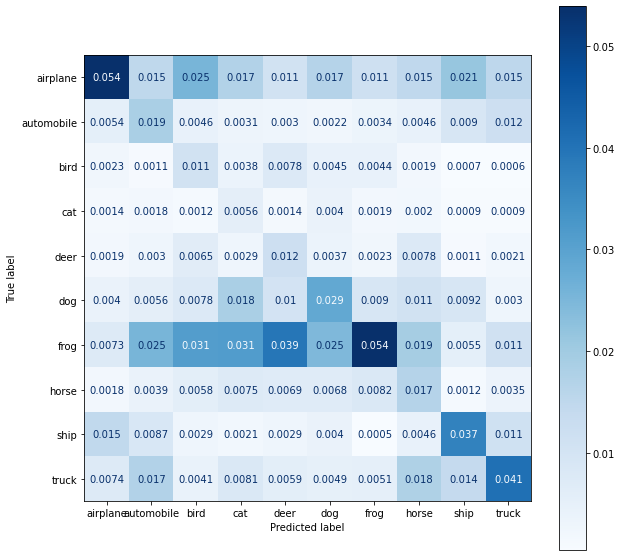

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display(torch.unique(preds, return_counts=True))

cm = confusion_matrix(preds, test_y,
                      normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes
                             )

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)

## 3. Implement a neural network

Create the initial neural network

In [25]:
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
device

device(type='cpu')

Prepare the data. To check code runs, I will do a tiny amount of training data.

We also flatten the image data to vectors so that we can feed into a basic NN.

In [26]:
num_epochs = 50
batch_size = 100
learning_rate = 0.005

# I wasn't going to copy Cactus_classification, but defining 'criterion'
# gives good flexibility
criterion = nn.CrossEntropyLoss()

#### Prepare data

The code below is almost an exact copy of cell 2, above. We've recreated to give us the flexibility to have a smaller training and test set whilst running on local machines. We also have target tranform below which one-hot-encodes the labels.

In [50]:
transform = transforms.Compose([transforms.ToTensor(), #transforms.Resize(32),
                                # transforms.Lambda(lambda x: torch.flatten(x))
                               ])
target_transforms = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float)
                                     .scatter_(0, torch.tensor(y), value=1))

# Prepare 1000 sample training set
CIFAR_data_small = CIFAR10(data_folder, train=True, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_data_small.data = CIFAR_data_small.data[10000:]
CIFAR_data_small.targets = CIFAR_data_small.targets[10000:]

# Prepare 1000 sample test set (weird balance, but easy to test)
CIFAR_test_small = CIFAR10(data_folder, train=False, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
# CIFAR_test_small.data = CIFAR_test_small.data[:5000]
# CIFAR_test_small.targets = CIFAR_test_small.targets[:5000]
CIFAR_test_small.data = CIFAR_data_small.data[:10000]
CIFAR_test_small.targets = CIFAR_data_small.targets[:10000]

train_small_dl = DataLoader(CIFAR_data_small,
                          batch_size=batch_size,
                          shuffle=True)

test_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

In [40]:
CIFAR_data_small.data.shape, type(CIFAR_data_small.data), CIFAR_test_small.data.shape

((40000, 32, 32, 3), numpy.ndarray, (10000, 32, 32, 3))

Check that we have one-hot encoded the labels data. Looks like we have!

In [29]:
train_features, train_labels = next(iter(test_small_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].permute(1,2,0)
label = train_labels[0]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100, 10])
Label: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [30]:
# Define model

# models should subclass nn.Module. Docs here:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # This flattens the 3 x 32 x 32 image matrices to vectors
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [31]:
# print("Model structure: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

## Training the model

In [32]:
def train_val(model, train_small_dl=train_small_dl, test_small_dl=test_small_dl, num_epochs=num_epochs, learning_rate=learning_rate, visible=True):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []
    valid_losses = []
    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0
    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    # validate-the-model
        model.eval()
        for data, target in test_small_dl:
        
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
            output = model(data)
        
            loss = criterion(output, target_i)
        
        # update-average-validation-loss 
            valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
        valid_loss = valid_loss/len(test_small_dl.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
        if visible:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # plot-training/validation-statistics
    if visible:
        plt.plot(np.arange(1, num_epochs + 1), train_losses, label = "Training")
        plt.plot(np.arange(1, num_epochs + 1), valid_losses, label = "Validation")
        plt.title("Loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

#simplified version of above without using test data
def train(model, train_small_dl=train_small_dl, num_epochs=num_epochs, learning_rate=learning_rate, visible=True):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []

    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0

    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
      
        train_losses.append(train_loss)
        
    # print-training/validation-statistics 
        if visible:
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # plot-training/validation-statistics
    if visible:
        plt.plot(np.arange(1, num_epochs + 1), train_losses, label = "Training")

        plt.title("Loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


Epoch: 1 	Training Loss: 2.292141
Epoch: 2 	Training Loss: 2.270898
Epoch: 3 	Training Loss: 2.248361
Epoch: 4 	Training Loss: 2.220323
Epoch: 5 	Training Loss: 2.187291
Epoch: 6 	Training Loss: 2.150683
Epoch: 7 	Training Loss: 2.115475
Epoch: 8 	Training Loss: 2.084544
Epoch: 9 	Training Loss: 2.058008
Epoch: 10 	Training Loss: 2.035158
Epoch: 11 	Training Loss: 2.013968
Epoch: 12 	Training Loss: 1.995528
Epoch: 13 	Training Loss: 1.979173
Epoch: 14 	Training Loss: 1.963954
Epoch: 15 	Training Loss: 1.949295
Epoch: 16 	Training Loss: 1.936788
Epoch: 17 	Training Loss: 1.924375
Epoch: 18 	Training Loss: 1.913410
Epoch: 19 	Training Loss: 1.903048
Epoch: 20 	Training Loss: 1.893184
Epoch: 21 	Training Loss: 1.884527
Epoch: 22 	Training Loss: 1.875624
Epoch: 23 	Training Loss: 1.867741
Epoch: 24 	Training Loss: 1.859854
Epoch: 25 	Training Loss: 1.852817
Epoch: 26 	Training Loss: 1.845032
Epoch: 27 	Training Loss: 1.837563
Epoch: 28 	Training Loss: 1.830474
Epoch: 29 	Training Loss: 1.8

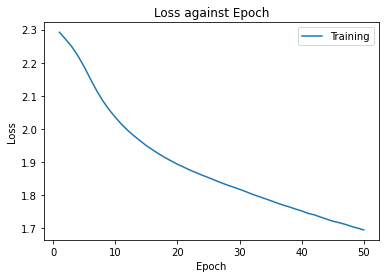

CPU times: user 2min 42s, sys: 1.5 s, total: 2min 43s
Wall time: 2min 28s


In [18]:
%%time
train(model)

## Test model on validation data

In [41]:
def test(model, test_small_dl=test_small_dl, visible=True):
    # test-the-model
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
    # below calculates accuracy. Alex adapted from lab code and
    # it's not very pretty code. I transformed labels from one-
    # hot-encoded to integer labels and did the same for the 
    # softmax output in `predicted`
        for images, labels in test_small_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data, dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels, dim=1)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct/total
        if visible:
            print('Test Accuracy of the model: {:.2f} %'.format(100 * accuracy))
    return accuracy

In [20]:
test(model)
# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 40.83 %


# Improvement

The accuracy doesn't look good enough. So let's explore any room for improvement, potentially:
- CNN
- Standard Normalization
- Regularization by dropout/L2
- More data
- tuning parameters: batch size, learning rate, no of epochs, optimizer

## CNN

CNN (convolutional neural network, also called ConvNet) is a popular technique for image classification in machine learning. Unlike traditional fully connected neural network, CNN somehow retains the spatial relationship among features (i.e. pixels) of images. In the below, we will keep the previous neural network structure in the end, but add CNN layers in the beginning. As the image is small, we will start with 3x3 kernel size, 2x2 max pooling, with suitable padding generating same output shape. 

Epoch: 1 	Training Loss: 2.264630
Epoch: 2 	Training Loss: 2.162396
Epoch: 3 	Training Loss: 2.074631
Epoch: 4 	Training Loss: 1.969891
Epoch: 5 	Training Loss: 1.916851
Epoch: 6 	Training Loss: 1.863221
Epoch: 7 	Training Loss: 1.803606
Epoch: 8 	Training Loss: 1.746756
Epoch: 9 	Training Loss: 1.694295
Epoch: 10 	Training Loss: 1.648990
Epoch: 11 	Training Loss: 1.600512
Epoch: 12 	Training Loss: 1.572895
Epoch: 13 	Training Loss: 1.518710
Epoch: 14 	Training Loss: 1.483392
Epoch: 15 	Training Loss: 1.401567
Epoch: 16 	Training Loss: 1.383542
Epoch: 17 	Training Loss: 1.307661
Epoch: 18 	Training Loss: 1.313913
Epoch: 19 	Training Loss: 1.246405
Epoch: 20 	Training Loss: 1.189045
Epoch: 21 	Training Loss: 1.174902
Epoch: 22 	Training Loss: 1.094390
Epoch: 23 	Training Loss: 1.031861
Epoch: 24 	Training Loss: 1.011416
Epoch: 25 	Training Loss: 0.960834
Epoch: 26 	Training Loss: 0.934500
Epoch: 27 	Training Loss: 0.884284
Epoch: 28 	Training Loss: 0.845436
Epoch: 29 	Training Loss: 0.7

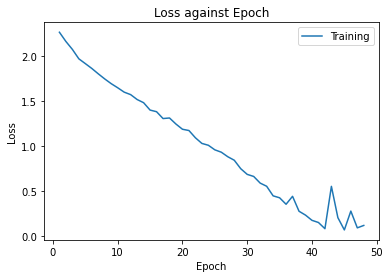

In [48]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN().to(device)


#train the model
train(net, learning_rate=0.1, num_epochs=48)

#save
torch.save(net.state_dict(), './cifar_net.pth')

In [49]:
test(net)

Test Accuracy of the model: 46.77 %


0.4677

Epoch: 1 	Training Loss: 2.296824
Epoch: 2 	Training Loss: 2.248217
Epoch: 3 	Training Loss: 2.179141
Epoch: 4 	Training Loss: 2.108301
Epoch: 5 	Training Loss: 2.034802
Epoch: 6 	Training Loss: 1.983895
Epoch: 7 	Training Loss: 1.946127
Epoch: 8 	Training Loss: 1.880391
Epoch: 9 	Training Loss: 1.859734
Epoch: 10 	Training Loss: 1.807585
Epoch: 11 	Training Loss: 1.780738
Epoch: 12 	Training Loss: 1.650136
Epoch: 13 	Training Loss: 1.613308
Epoch: 14 	Training Loss: 1.546165
Epoch: 15 	Training Loss: 1.510726
Epoch: 16 	Training Loss: 1.474273
Epoch: 17 	Training Loss: 1.422767
Epoch: 18 	Training Loss: 1.391157
Epoch: 19 	Training Loss: 1.344028
Epoch: 20 	Training Loss: 1.304994
Epoch: 21 	Training Loss: 1.268007
Epoch: 22 	Training Loss: 1.223723
Epoch: 23 	Training Loss: 1.173326
Epoch: 24 	Training Loss: 1.121641
Epoch: 25 	Training Loss: 1.099220
Epoch: 26 	Training Loss: 1.028457
Epoch: 27 	Training Loss: 0.990548
Epoch: 28 	Training Loss: 0.917040
Epoch: 29 	Training Loss: 0.8

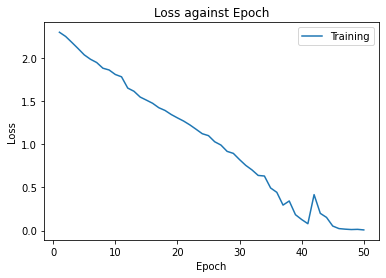

In [44]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net2 = CNN2()


#train the model
train(net2, learning_rate=0.1)

#save
torch.save(net2.state_dict(), './cifar_net2.pth')

In [45]:
test(net2)

Test Accuracy of the model: 53.01 %


0.5301

## Next step after achieving accuracy 100.0% 
(running twice to double check results before fixed random seed is added). There should be little room for further improvement and no need for further tuning and testing parameters, except for experiment purpose. Please note that according to PyTorch, completely reproducible results are not guaranteed across PyTorch releases, individual commits, different platforms, or between CPU and GPU executions. (https://pytorch.org/docs/stable/notes/randomness.html).

Epoch: 1 	Training Loss: 2.193261
Epoch: 2 	Training Loss: 1.964158
Epoch: 3 	Training Loss: 1.820964
Epoch: 4 	Training Loss: 1.700214
Epoch: 5 	Training Loss: 1.625232
Epoch: 6 	Training Loss: 1.526592
Epoch: 7 	Training Loss: 1.448523
Epoch: 8 	Training Loss: 1.379457
Epoch: 9 	Training Loss: 1.312498
Epoch: 10 	Training Loss: 1.238861
Epoch: 11 	Training Loss: 1.189518
Epoch: 12 	Training Loss: 1.125614
Epoch: 13 	Training Loss: 1.063727
Epoch: 14 	Training Loss: 1.009492
Epoch: 15 	Training Loss: 0.944752
Epoch: 16 	Training Loss: 0.886249
Epoch: 17 	Training Loss: 0.810232
Epoch: 18 	Training Loss: 0.755692
Epoch: 19 	Training Loss: 0.674731
Epoch: 20 	Training Loss: 0.632979
Epoch: 21 	Training Loss: 0.528030
Epoch: 22 	Training Loss: 0.481074
Epoch: 23 	Training Loss: 0.441357
Epoch: 24 	Training Loss: 0.357586
Epoch: 25 	Training Loss: 0.312422
Epoch: 26 	Training Loss: 0.242634
Epoch: 27 	Training Loss: 0.221936
Epoch: 28 	Training Loss: 0.176697
Epoch: 29 	Training Loss: 0.1

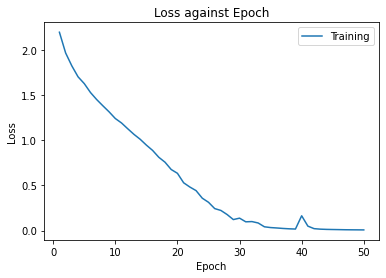

Test Accuracy of the model: 99.96 %


0.9996

In [25]:
#simplify by cutting one FC layer of CNN
class CNN1_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1_2 = CNN1_2()


#train the model
train(net1_2, learning_rate=0.1)

#save
torch.save(net1_2.state_dict(), './cifar_net1_2.pth')

#testing vs test set
test(net1_2)

Epoch: 1 	Training Loss: 2.269969
Epoch: 2 	Training Loss: 2.222090
Epoch: 3 	Training Loss: 2.186444
Epoch: 4 	Training Loss: 2.166350
Epoch: 5 	Training Loss: 2.151270
Epoch: 6 	Training Loss: 2.137274
Epoch: 7 	Training Loss: 2.109276
Epoch: 8 	Training Loss: 2.078781
Epoch: 9 	Training Loss: 2.063278
Epoch: 10 	Training Loss: 2.040971
Epoch: 11 	Training Loss: 2.025205
Epoch: 12 	Training Loss: 2.010685
Epoch: 13 	Training Loss: 2.003384
Epoch: 14 	Training Loss: 1.985814
Epoch: 15 	Training Loss: 1.982162
Epoch: 16 	Training Loss: 1.964011
Epoch: 17 	Training Loss: 1.952077
Epoch: 18 	Training Loss: 1.928386
Epoch: 19 	Training Loss: 1.865403
Epoch: 20 	Training Loss: 1.835472
Epoch: 21 	Training Loss: 1.818772
Epoch: 22 	Training Loss: 1.801913
Epoch: 23 	Training Loss: 1.761089
Epoch: 24 	Training Loss: 1.751514
Epoch: 25 	Training Loss: 1.731716
Epoch: 26 	Training Loss: 1.710994
Epoch: 27 	Training Loss: 1.699220
Epoch: 28 	Training Loss: 1.682486
Epoch: 29 	Training Loss: 1.6

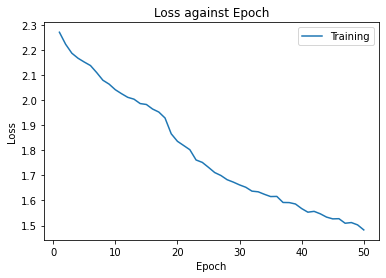

Test Accuracy of the model: 53.98 %


0.5398

In [26]:
#simplify by cutting two FC layers of CNN
class CNN1_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

net1_3 = CNN1_3()


#train the model
train(net1_3, learning_rate=0.1)

#save
torch.save(net1_3.state_dict(), './cifar_net1_3.pth')

#testing vs test set
test(net1_3)

# Test and Evaluate Parameters

Since the data is balanced among different classes, we can simply use accuracy to evaluate models and ignore confusion matrix. As we have model attaining accuracy of 99.9% or 100.0% in test data, we don't need to worry about over-fitting and regularization and will choose the simplest structure for evaluating different parameters. i.e. the net1_2, which consists of 1 convolutional layer (12 channels, kernels size 3, with MaxPool(2,2) then RELU), followed by 1 hidden fully connected layer (512 nodes) and 1 output layer (10 classes). 

In [27]:
#create a general class of CNN with 1 conv layer, 1 hidden FC layer and 1 output layer
class CNN_variant(nn.Module):
    def __init__(self, k=12, n=512):
        super().__init__()
        self.conv1 = nn.Conv2d(3, k, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(256*k, n)
        self.fc2 = nn.Linear(n, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch: 1 	Training Loss: 2.219592
Epoch: 2 	Training Loss: 2.007609
Epoch: 3 	Training Loss: 1.880477
Epoch: 4 	Training Loss: 1.786821
Epoch: 5 	Training Loss: 1.725927
Epoch: 6 	Training Loss: 1.668197
Epoch: 7 	Training Loss: 1.625173
Epoch: 8 	Training Loss: 1.585517
Epoch: 9 	Training Loss: 1.538862
Epoch: 10 	Training Loss: 1.520524
Epoch: 11 	Training Loss: 1.466187
Epoch: 12 	Training Loss: 1.425226
Epoch: 13 	Training Loss: 1.389999
Epoch: 14 	Training Loss: 1.358227
Epoch: 15 	Training Loss: 1.337434
Epoch: 16 	Training Loss: 1.306545
Epoch: 17 	Training Loss: 1.292475
Epoch: 18 	Training Loss: 1.247393
Epoch: 19 	Training Loss: 1.217646
Epoch: 20 	Training Loss: 1.189784
Epoch: 21 	Training Loss: 1.156126
Epoch: 22 	Training Loss: 1.132336
Epoch: 23 	Training Loss: 1.097873
Epoch: 24 	Training Loss: 1.065226
Epoch: 25 	Training Loss: 1.032341
Epoch: 26 	Training Loss: 0.992422
Epoch: 27 	Training Loss: 0.969664
Epoch: 28 	Training Loss: 0.915252
Epoch: 29 	Training Loss: 0.9

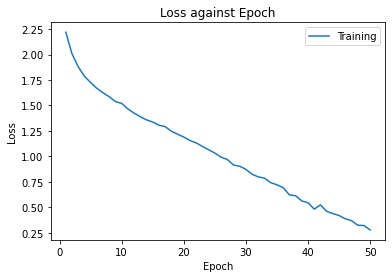

Test Accuracy of the model: 92.50 %
done for k=3; n=128
Epoch: 1 	Training Loss: 2.221934
Epoch: 2 	Training Loss: 2.015706
Epoch: 3 	Training Loss: 1.881038
Epoch: 4 	Training Loss: 1.760066
Epoch: 5 	Training Loss: 1.688962
Epoch: 6 	Training Loss: 1.616961
Epoch: 7 	Training Loss: 1.549038
Epoch: 8 	Training Loss: 1.494238
Epoch: 9 	Training Loss: 1.454548
Epoch: 10 	Training Loss: 1.414886
Epoch: 11 	Training Loss: 1.357575
Epoch: 12 	Training Loss: 1.327094
Epoch: 13 	Training Loss: 1.286941
Epoch: 14 	Training Loss: 1.249252
Epoch: 15 	Training Loss: 1.209171
Epoch: 16 	Training Loss: 1.163454
Epoch: 17 	Training Loss: 1.119864
Epoch: 18 	Training Loss: 1.075310
Epoch: 19 	Training Loss: 1.030001
Epoch: 20 	Training Loss: 0.990675
Epoch: 21 	Training Loss: 0.943085
Epoch: 22 	Training Loss: 0.930069
Epoch: 23 	Training Loss: 0.876764
Epoch: 24 	Training Loss: 0.821975
Epoch: 25 	Training Loss: 0.789674
Epoch: 26 	Training Loss: 0.707553
Epoch: 27 	Training Loss: 0.690153
Epoch: 2

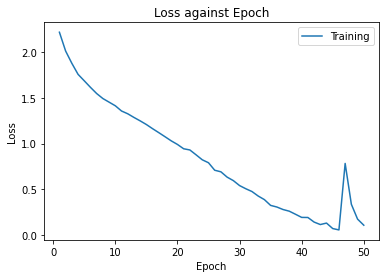

Test Accuracy of the model: 97.95 %
done for k=3; n=256
Epoch: 1 	Training Loss: 2.207206
Epoch: 2 	Training Loss: 2.058926
Epoch: 3 	Training Loss: 1.933922
Epoch: 4 	Training Loss: 1.840033
Epoch: 5 	Training Loss: 1.761915
Epoch: 6 	Training Loss: 1.686726
Epoch: 7 	Training Loss: 1.651874
Epoch: 8 	Training Loss: 1.602437
Epoch: 9 	Training Loss: 1.572688
Epoch: 10 	Training Loss: 1.542392
Epoch: 11 	Training Loss: 1.497621
Epoch: 12 	Training Loss: 1.465854
Epoch: 13 	Training Loss: 1.423434
Epoch: 14 	Training Loss: 1.401860
Epoch: 15 	Training Loss: 1.355160
Epoch: 16 	Training Loss: 1.322257
Epoch: 17 	Training Loss: 1.269174
Epoch: 18 	Training Loss: 1.229458
Epoch: 19 	Training Loss: 1.178702
Epoch: 20 	Training Loss: 1.126693
Epoch: 21 	Training Loss: 1.087347
Epoch: 22 	Training Loss: 1.025529
Epoch: 23 	Training Loss: 0.977590
Epoch: 24 	Training Loss: 0.919652
Epoch: 25 	Training Loss: 0.872863
Epoch: 26 	Training Loss: 0.830420
Epoch: 27 	Training Loss: 0.763091
Epoch: 2

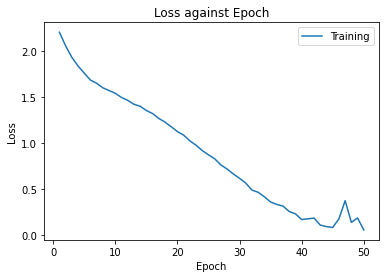

Test Accuracy of the model: 98.22 %
done for k=3; n=512
Epoch: 1 	Training Loss: 2.260004
Epoch: 2 	Training Loss: 2.068192
Epoch: 3 	Training Loss: 1.950454
Epoch: 4 	Training Loss: 1.863902
Epoch: 5 	Training Loss: 1.779323
Epoch: 6 	Training Loss: 1.724854
Epoch: 7 	Training Loss: 1.664754
Epoch: 8 	Training Loss: 1.611364
Epoch: 9 	Training Loss: 1.566767
Epoch: 10 	Training Loss: 1.524077
Epoch: 11 	Training Loss: 1.476243
Epoch: 12 	Training Loss: 1.431212
Epoch: 13 	Training Loss: 1.409388
Epoch: 14 	Training Loss: 1.361154
Epoch: 15 	Training Loss: 1.320596
Epoch: 16 	Training Loss: 1.282756
Epoch: 17 	Training Loss: 1.227541
Epoch: 18 	Training Loss: 1.188873
Epoch: 19 	Training Loss: 1.144956
Epoch: 20 	Training Loss: 1.091560
Epoch: 21 	Training Loss: 1.046835
Epoch: 22 	Training Loss: 0.998303
Epoch: 23 	Training Loss: 0.945135
Epoch: 24 	Training Loss: 0.894796
Epoch: 25 	Training Loss: 0.822268
Epoch: 26 	Training Loss: 0.794284
Epoch: 27 	Training Loss: 0.722252
Epoch: 2

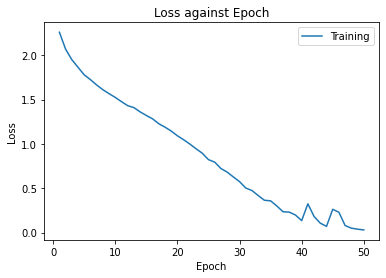

Test Accuracy of the model: 99.87 %
done for k=3; n=1024
Epoch: 1 	Training Loss: 2.238525
Epoch: 2 	Training Loss: 2.032782
Epoch: 3 	Training Loss: 1.932031
Epoch: 4 	Training Loss: 1.871253
Epoch: 5 	Training Loss: 1.814857
Epoch: 6 	Training Loss: 1.780167
Epoch: 7 	Training Loss: 1.740967
Epoch: 8 	Training Loss: 1.709071
Epoch: 9 	Training Loss: 1.692127
Epoch: 10 	Training Loss: 1.656818
Epoch: 11 	Training Loss: 1.643582
Epoch: 12 	Training Loss: 1.611600
Epoch: 13 	Training Loss: 1.590728
Epoch: 14 	Training Loss: 1.559959
Epoch: 15 	Training Loss: 1.539051
Epoch: 16 	Training Loss: 1.533917
Epoch: 17 	Training Loss: 1.501591
Epoch: 18 	Training Loss: 1.477442
Epoch: 19 	Training Loss: 1.462360
Epoch: 20 	Training Loss: 1.432735
Epoch: 21 	Training Loss: 1.416284
Epoch: 22 	Training Loss: 1.370264
Epoch: 23 	Training Loss: 1.341190
Epoch: 24 	Training Loss: 1.311794
Epoch: 25 	Training Loss: 1.277635
Epoch: 26 	Training Loss: 1.249475
Epoch: 27 	Training Loss: 1.228583
Epoch: 

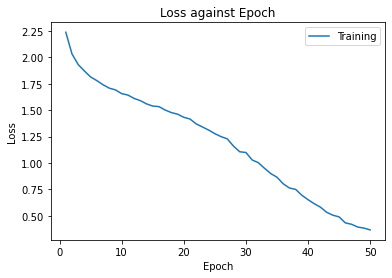

Test Accuracy of the model: 90.29 %
done for k=3; n=2048
Epoch: 1 	Training Loss: 2.227640
Epoch: 2 	Training Loss: 2.044284
Epoch: 3 	Training Loss: 1.889212
Epoch: 4 	Training Loss: 1.794931
Epoch: 5 	Training Loss: 1.725590
Epoch: 6 	Training Loss: 1.669649
Epoch: 7 	Training Loss: 1.609695
Epoch: 8 	Training Loss: 1.543146
Epoch: 9 	Training Loss: 1.501654
Epoch: 10 	Training Loss: 1.464632
Epoch: 11 	Training Loss: 1.401855
Epoch: 12 	Training Loss: 1.361918
Epoch: 13 	Training Loss: 1.330752
Epoch: 14 	Training Loss: 1.292862
Epoch: 15 	Training Loss: 1.248409
Epoch: 16 	Training Loss: 1.204837
Epoch: 17 	Training Loss: 1.170699
Epoch: 18 	Training Loss: 1.121281
Epoch: 19 	Training Loss: 1.091727
Epoch: 20 	Training Loss: 1.047140
Epoch: 21 	Training Loss: 1.012240
Epoch: 22 	Training Loss: 0.952301
Epoch: 23 	Training Loss: 0.921551
Epoch: 24 	Training Loss: 0.889940
Epoch: 25 	Training Loss: 0.852587
Epoch: 26 	Training Loss: 0.799736
Epoch: 27 	Training Loss: 0.766110
Epoch: 

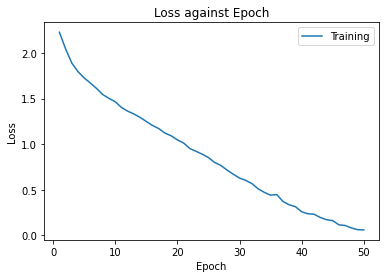

Test Accuracy of the model: 99.26 %
done for k=6; n=128
Epoch: 1 	Training Loss: 2.210233
Epoch: 2 	Training Loss: 2.002198
Epoch: 3 	Training Loss: 1.850703
Epoch: 4 	Training Loss: 1.760807
Epoch: 5 	Training Loss: 1.658267
Epoch: 6 	Training Loss: 1.587075
Epoch: 7 	Training Loss: 1.529924
Epoch: 8 	Training Loss: 1.459781
Epoch: 9 	Training Loss: 1.417852
Epoch: 10 	Training Loss: 1.360789
Epoch: 11 	Training Loss: 1.305520
Epoch: 12 	Training Loss: 1.267360
Epoch: 13 	Training Loss: 1.213192
Epoch: 14 	Training Loss: 1.168289
Epoch: 15 	Training Loss: 1.118935
Epoch: 16 	Training Loss: 1.060022
Epoch: 17 	Training Loss: 1.026914
Epoch: 18 	Training Loss: 0.968898
Epoch: 19 	Training Loss: 0.923267
Epoch: 20 	Training Loss: 0.852271
Epoch: 21 	Training Loss: 0.795440
Epoch: 22 	Training Loss: 0.749412
Epoch: 23 	Training Loss: 0.680734
Epoch: 24 	Training Loss: 0.623417
Epoch: 25 	Training Loss: 0.555411
Epoch: 26 	Training Loss: 0.503758
Epoch: 27 	Training Loss: 0.448596
Epoch: 2

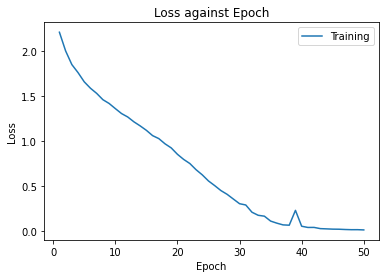

Test Accuracy of the model: 99.97 %
done for k=6; n=256
Epoch: 1 	Training Loss: 2.169838
Epoch: 2 	Training Loss: 1.962508
Epoch: 3 	Training Loss: 1.836914
Epoch: 4 	Training Loss: 1.768717
Epoch: 5 	Training Loss: 1.689298
Epoch: 6 	Training Loss: 1.615628
Epoch: 7 	Training Loss: 1.574953
Epoch: 8 	Training Loss: 1.507225
Epoch: 9 	Training Loss: 1.452913
Epoch: 10 	Training Loss: 1.384932
Epoch: 11 	Training Loss: 1.329787
Epoch: 12 	Training Loss: 1.285198
Epoch: 13 	Training Loss: 1.230788
Epoch: 14 	Training Loss: 1.168345
Epoch: 15 	Training Loss: 1.140568
Epoch: 16 	Training Loss: 1.090431
Epoch: 17 	Training Loss: 1.036747
Epoch: 18 	Training Loss: 0.980847
Epoch: 19 	Training Loss: 0.930917
Epoch: 20 	Training Loss: 0.875730
Epoch: 21 	Training Loss: 0.821813
Epoch: 22 	Training Loss: 0.772948
Epoch: 23 	Training Loss: 0.715037
Epoch: 24 	Training Loss: 0.670675
Epoch: 25 	Training Loss: 0.620694
Epoch: 26 	Training Loss: 0.560564
Epoch: 27 	Training Loss: 0.521104
Epoch: 2

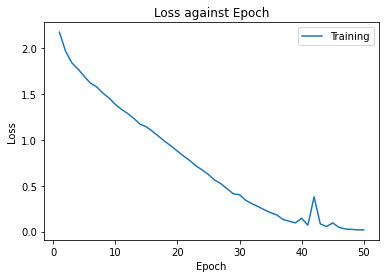

Test Accuracy of the model: 99.92 %
done for k=6; n=512
Epoch: 1 	Training Loss: 2.169245
Epoch: 2 	Training Loss: 1.939358
Epoch: 3 	Training Loss: 1.809617
Epoch: 4 	Training Loss: 1.716029
Epoch: 5 	Training Loss: 1.632950
Epoch: 6 	Training Loss: 1.566028
Epoch: 7 	Training Loss: 1.510026
Epoch: 8 	Training Loss: 1.436509
Epoch: 9 	Training Loss: 1.402526
Epoch: 10 	Training Loss: 1.346916
Epoch: 11 	Training Loss: 1.290914
Epoch: 12 	Training Loss: 1.247389
Epoch: 13 	Training Loss: 1.196005
Epoch: 14 	Training Loss: 1.145104
Epoch: 15 	Training Loss: 1.077191
Epoch: 16 	Training Loss: 1.031845
Epoch: 17 	Training Loss: 0.985185
Epoch: 18 	Training Loss: 0.924942
Epoch: 19 	Training Loss: 0.852191
Epoch: 20 	Training Loss: 0.802643
Epoch: 21 	Training Loss: 0.736909
Epoch: 22 	Training Loss: 0.678062
Epoch: 23 	Training Loss: 0.616398
Epoch: 24 	Training Loss: 0.553799
Epoch: 25 	Training Loss: 0.503977
Epoch: 26 	Training Loss: 0.438027
Epoch: 27 	Training Loss: 0.385770
Epoch: 2

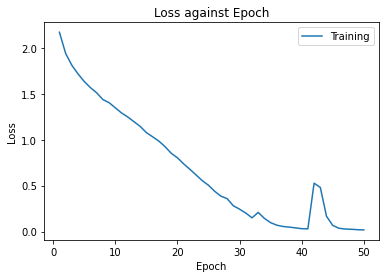

Test Accuracy of the model: 99.90 %
done for k=6; n=1024
Epoch: 1 	Training Loss: 2.164430
Epoch: 2 	Training Loss: 1.949794
Epoch: 3 	Training Loss: 1.784079
Epoch: 4 	Training Loss: 1.675145
Epoch: 5 	Training Loss: 1.581777
Epoch: 6 	Training Loss: 1.521020
Epoch: 7 	Training Loss: 1.445154
Epoch: 8 	Training Loss: 1.378615
Epoch: 9 	Training Loss: 1.329402
Epoch: 10 	Training Loss: 1.270194
Epoch: 11 	Training Loss: 1.210663
Epoch: 12 	Training Loss: 1.148250
Epoch: 13 	Training Loss: 1.088373
Epoch: 14 	Training Loss: 1.030087
Epoch: 15 	Training Loss: 0.963039
Epoch: 16 	Training Loss: 0.908296
Epoch: 17 	Training Loss: 0.814700
Epoch: 18 	Training Loss: 0.741230
Epoch: 19 	Training Loss: 0.687165
Epoch: 20 	Training Loss: 0.599649
Epoch: 21 	Training Loss: 0.539631
Epoch: 22 	Training Loss: 0.479206
Epoch: 23 	Training Loss: 0.424682
Epoch: 24 	Training Loss: 0.372014
Epoch: 25 	Training Loss: 0.282537
Epoch: 26 	Training Loss: 0.244329
Epoch: 27 	Training Loss: 0.168035
Epoch: 

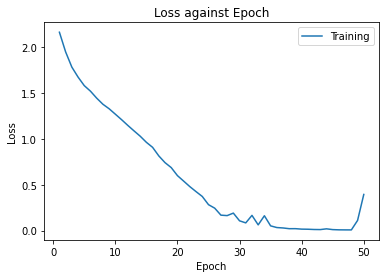

Test Accuracy of the model: 98.65 %
done for k=6; n=2048
Epoch: 1 	Training Loss: 2.194229
Epoch: 2 	Training Loss: 1.993786
Epoch: 3 	Training Loss: 1.840844
Epoch: 4 	Training Loss: 1.721135
Epoch: 5 	Training Loss: 1.641421
Epoch: 6 	Training Loss: 1.568770
Epoch: 7 	Training Loss: 1.494212
Epoch: 8 	Training Loss: 1.413807
Epoch: 9 	Training Loss: 1.347160
Epoch: 10 	Training Loss: 1.294336
Epoch: 11 	Training Loss: 1.209020
Epoch: 12 	Training Loss: 1.151584
Epoch: 13 	Training Loss: 1.121933
Epoch: 14 	Training Loss: 1.043052
Epoch: 15 	Training Loss: 0.999245
Epoch: 16 	Training Loss: 0.934235
Epoch: 17 	Training Loss: 0.893595
Epoch: 18 	Training Loss: 0.824445
Epoch: 19 	Training Loss: 0.775296
Epoch: 20 	Training Loss: 0.714156
Epoch: 21 	Training Loss: 0.649730
Epoch: 22 	Training Loss: 0.589844
Epoch: 23 	Training Loss: 0.527146
Epoch: 24 	Training Loss: 0.481362
Epoch: 25 	Training Loss: 0.449106
Epoch: 26 	Training Loss: 0.375617
Epoch: 27 	Training Loss: 0.338464
Epoch: 

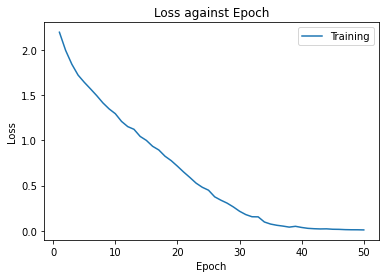

Test Accuracy of the model: 99.99 %
done for k=12; n=128
Epoch: 1 	Training Loss: 2.192228
Epoch: 2 	Training Loss: 2.000785
Epoch: 3 	Training Loss: 1.861121
Epoch: 4 	Training Loss: 1.760100
Epoch: 5 	Training Loss: 1.693168
Epoch: 6 	Training Loss: 1.609737
Epoch: 7 	Training Loss: 1.525546
Epoch: 8 	Training Loss: 1.465189
Epoch: 9 	Training Loss: 1.394881
Epoch: 10 	Training Loss: 1.323807
Epoch: 11 	Training Loss: 1.278341
Epoch: 12 	Training Loss: 1.230257
Epoch: 13 	Training Loss: 1.180053
Epoch: 14 	Training Loss: 1.122913
Epoch: 15 	Training Loss: 1.065633
Epoch: 16 	Training Loss: 1.029639
Epoch: 17 	Training Loss: 0.981855
Epoch: 18 	Training Loss: 0.920222
Epoch: 19 	Training Loss: 0.865734
Epoch: 20 	Training Loss: 0.807963
Epoch: 21 	Training Loss: 0.745528
Epoch: 22 	Training Loss: 0.697840
Epoch: 23 	Training Loss: 0.625903
Epoch: 24 	Training Loss: 0.571154
Epoch: 25 	Training Loss: 0.534718
Epoch: 26 	Training Loss: 0.467162
Epoch: 27 	Training Loss: 0.418525
Epoch: 

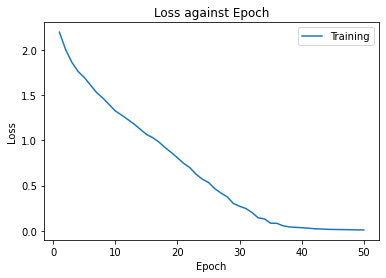

Test Accuracy of the model: 99.96 %
done for k=12; n=256
Epoch: 1 	Training Loss: 2.203165
Epoch: 2 	Training Loss: 1.970492
Epoch: 3 	Training Loss: 1.832969
Epoch: 4 	Training Loss: 1.691387
Epoch: 5 	Training Loss: 1.598753
Epoch: 6 	Training Loss: 1.503851
Epoch: 7 	Training Loss: 1.439865
Epoch: 8 	Training Loss: 1.366040
Epoch: 9 	Training Loss: 1.284132
Epoch: 10 	Training Loss: 1.227900
Epoch: 11 	Training Loss: 1.144001
Epoch: 12 	Training Loss: 1.083964
Epoch: 13 	Training Loss: 1.016593
Epoch: 14 	Training Loss: 0.939723
Epoch: 15 	Training Loss: 0.886154
Epoch: 16 	Training Loss: 0.814267
Epoch: 17 	Training Loss: 0.739304
Epoch: 18 	Training Loss: 0.669334
Epoch: 19 	Training Loss: 0.600008
Epoch: 20 	Training Loss: 0.545947
Epoch: 21 	Training Loss: 0.463123
Epoch: 22 	Training Loss: 0.422635
Epoch: 23 	Training Loss: 0.347408
Epoch: 24 	Training Loss: 0.289765
Epoch: 25 	Training Loss: 0.229082
Epoch: 26 	Training Loss: 0.192300
Epoch: 27 	Training Loss: 0.176598
Epoch: 

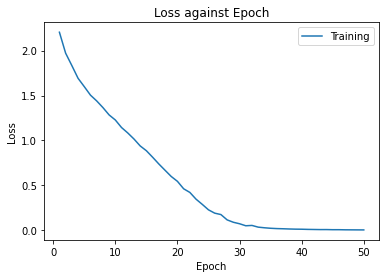

Test Accuracy of the model: 100.00 %
done for k=12; n=512
Epoch: 1 	Training Loss: 2.187186
Epoch: 2 	Training Loss: 1.967023
Epoch: 3 	Training Loss: 1.813169
Epoch: 4 	Training Loss: 1.696694
Epoch: 5 	Training Loss: 1.603386
Epoch: 6 	Training Loss: 1.536168
Epoch: 7 	Training Loss: 1.445431
Epoch: 8 	Training Loss: 1.393383
Epoch: 9 	Training Loss: 1.301465
Epoch: 10 	Training Loss: 1.228409
Epoch: 11 	Training Loss: 1.179848
Epoch: 12 	Training Loss: 1.101737
Epoch: 13 	Training Loss: 1.034559
Epoch: 14 	Training Loss: 0.958057
Epoch: 15 	Training Loss: 0.900372
Epoch: 16 	Training Loss: 0.838091
Epoch: 17 	Training Loss: 0.763249
Epoch: 18 	Training Loss: 0.706616
Epoch: 19 	Training Loss: 0.602726
Epoch: 20 	Training Loss: 0.562366
Epoch: 21 	Training Loss: 0.490464
Epoch: 22 	Training Loss: 0.416709
Epoch: 23 	Training Loss: 0.362939
Epoch: 24 	Training Loss: 0.317638
Epoch: 25 	Training Loss: 0.274354
Epoch: 26 	Training Loss: 0.216081
Epoch: 27 	Training Loss: 0.209006
Epoch:

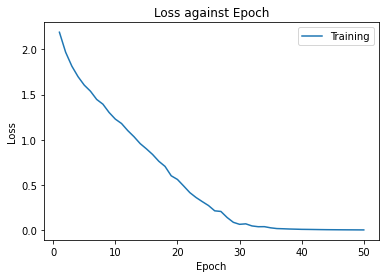

Test Accuracy of the model: 100.00 %
done for k=12; n=1024
Epoch: 1 	Training Loss: 2.142860
Epoch: 2 	Training Loss: 1.937417
Epoch: 3 	Training Loss: 1.777527
Epoch: 4 	Training Loss: 1.670365
Epoch: 5 	Training Loss: 1.561479
Epoch: 6 	Training Loss: 1.462145
Epoch: 7 	Training Loss: 1.380708
Epoch: 8 	Training Loss: 1.306277
Epoch: 9 	Training Loss: 1.239163
Epoch: 10 	Training Loss: 1.161235
Epoch: 11 	Training Loss: 1.084135
Epoch: 12 	Training Loss: 1.022864
Epoch: 13 	Training Loss: 0.949034
Epoch: 14 	Training Loss: 0.869856
Epoch: 15 	Training Loss: 0.794706
Epoch: 16 	Training Loss: 0.740237
Epoch: 17 	Training Loss: 0.647028
Epoch: 18 	Training Loss: 0.599976
Epoch: 19 	Training Loss: 0.506661
Epoch: 20 	Training Loss: 0.434266
Epoch: 21 	Training Loss: 0.376178
Epoch: 22 	Training Loss: 0.304098
Epoch: 23 	Training Loss: 0.256470
Epoch: 24 	Training Loss: 0.214727
Epoch: 25 	Training Loss: 0.236859
Epoch: 26 	Training Loss: 0.156575
Epoch: 27 	Training Loss: 0.116859
Epoch

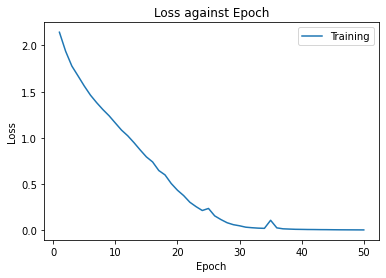

Test Accuracy of the model: 100.00 %
done for k=12; n=2048
Epoch: 1 	Training Loss: 2.205107
Epoch: 2 	Training Loss: 2.001943
Epoch: 3 	Training Loss: 1.860039
Epoch: 4 	Training Loss: 1.741937
Epoch: 5 	Training Loss: 1.639209
Epoch: 6 	Training Loss: 1.556177
Epoch: 7 	Training Loss: 1.456859
Epoch: 8 	Training Loss: 1.377203
Epoch: 9 	Training Loss: 1.305105
Epoch: 10 	Training Loss: 1.234190
Epoch: 11 	Training Loss: 1.202556
Epoch: 12 	Training Loss: 1.115113
Epoch: 13 	Training Loss: 1.066173
Epoch: 14 	Training Loss: 0.997079
Epoch: 15 	Training Loss: 0.968196
Epoch: 16 	Training Loss: 0.892825
Epoch: 17 	Training Loss: 0.849417
Epoch: 18 	Training Loss: 0.770044
Epoch: 19 	Training Loss: 0.732770
Epoch: 20 	Training Loss: 0.685426
Epoch: 21 	Training Loss: 0.607617
Epoch: 22 	Training Loss: 0.558418
Epoch: 23 	Training Loss: 0.512727
Epoch: 24 	Training Loss: 0.453029
Epoch: 25 	Training Loss: 0.402587
Epoch: 26 	Training Loss: 0.345379
Epoch: 27 	Training Loss: 0.290302
Epoch

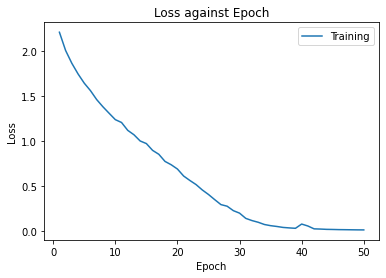

Test Accuracy of the model: 99.99 %
done for k=24; n=128
Epoch: 1 	Training Loss: 2.171271
Epoch: 2 	Training Loss: 1.938347
Epoch: 3 	Training Loss: 1.798919
Epoch: 4 	Training Loss: 1.694380
Epoch: 5 	Training Loss: 1.612175
Epoch: 6 	Training Loss: 1.519180
Epoch: 7 	Training Loss: 1.435263
Epoch: 8 	Training Loss: 1.378168
Epoch: 9 	Training Loss: 1.299662
Epoch: 10 	Training Loss: 1.212083
Epoch: 11 	Training Loss: 1.171630
Epoch: 12 	Training Loss: 1.100163
Epoch: 13 	Training Loss: 1.045052
Epoch: 14 	Training Loss: 0.989005
Epoch: 15 	Training Loss: 0.907038
Epoch: 16 	Training Loss: 0.863626
Epoch: 17 	Training Loss: 0.796526
Epoch: 18 	Training Loss: 0.721874
Epoch: 19 	Training Loss: 0.663798
Epoch: 20 	Training Loss: 0.593008
Epoch: 21 	Training Loss: 0.527718
Epoch: 22 	Training Loss: 0.463662
Epoch: 23 	Training Loss: 0.401067
Epoch: 24 	Training Loss: 0.376093
Epoch: 25 	Training Loss: 0.310858
Epoch: 26 	Training Loss: 0.242950
Epoch: 27 	Training Loss: 0.210982
Epoch: 

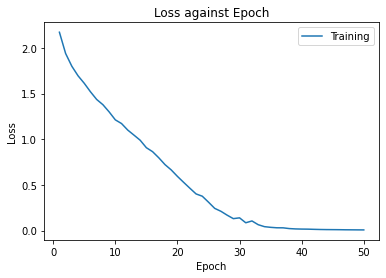

Test Accuracy of the model: 99.99 %
done for k=24; n=256
Epoch: 1 	Training Loss: 2.160459
Epoch: 2 	Training Loss: 1.906045
Epoch: 3 	Training Loss: 1.786184
Epoch: 4 	Training Loss: 1.647997
Epoch: 5 	Training Loss: 1.545773
Epoch: 6 	Training Loss: 1.468902
Epoch: 7 	Training Loss: 1.369705
Epoch: 8 	Training Loss: 1.310099
Epoch: 9 	Training Loss: 1.230506
Epoch: 10 	Training Loss: 1.176811
Epoch: 11 	Training Loss: 1.107405
Epoch: 12 	Training Loss: 1.047276
Epoch: 13 	Training Loss: 0.979788
Epoch: 14 	Training Loss: 0.898773
Epoch: 15 	Training Loss: 0.852484
Epoch: 16 	Training Loss: 0.781037
Epoch: 17 	Training Loss: 0.703056
Epoch: 18 	Training Loss: 0.655332
Epoch: 19 	Training Loss: 0.573939
Epoch: 20 	Training Loss: 0.512630
Epoch: 21 	Training Loss: 0.448686
Epoch: 22 	Training Loss: 0.404556
Epoch: 23 	Training Loss: 0.322443
Epoch: 24 	Training Loss: 0.281285
Epoch: 25 	Training Loss: 0.210124
Epoch: 26 	Training Loss: 0.178336
Epoch: 27 	Training Loss: 0.140510
Epoch: 

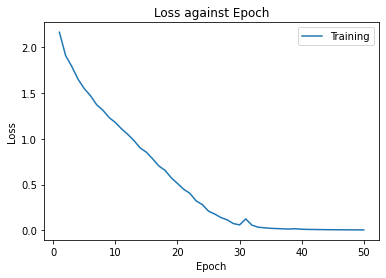

Test Accuracy of the model: 100.00 %
done for k=24; n=512
Epoch: 1 	Training Loss: 2.120108
Epoch: 2 	Training Loss: 1.896198
Epoch: 3 	Training Loss: 1.754005
Epoch: 4 	Training Loss: 1.639248
Epoch: 5 	Training Loss: 1.541815
Epoch: 6 	Training Loss: 1.443098
Epoch: 7 	Training Loss: 1.375751
Epoch: 8 	Training Loss: 1.292868
Epoch: 9 	Training Loss: 1.236110
Epoch: 10 	Training Loss: 1.156556
Epoch: 11 	Training Loss: 1.101767
Epoch: 12 	Training Loss: 1.035293
Epoch: 13 	Training Loss: 0.948882
Epoch: 14 	Training Loss: 0.876524
Epoch: 15 	Training Loss: 0.828811
Epoch: 16 	Training Loss: 0.748537
Epoch: 17 	Training Loss: 0.666370
Epoch: 18 	Training Loss: 0.597997
Epoch: 19 	Training Loss: 0.537109
Epoch: 20 	Training Loss: 0.451036
Epoch: 21 	Training Loss: 0.393585
Epoch: 22 	Training Loss: 0.324812
Epoch: 23 	Training Loss: 0.283550
Epoch: 24 	Training Loss: 0.210971
Epoch: 25 	Training Loss: 0.170428
Epoch: 26 	Training Loss: 0.124909
Epoch: 27 	Training Loss: 0.141704
Epoch:

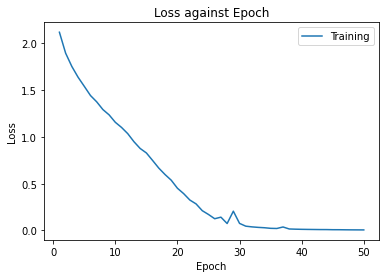

Test Accuracy of the model: 100.00 %
done for k=24; n=1024
Epoch: 1 	Training Loss: 2.148500
Epoch: 2 	Training Loss: 1.927065
Epoch: 3 	Training Loss: 1.790056
Epoch: 4 	Training Loss: 1.653921
Epoch: 5 	Training Loss: 1.570174
Epoch: 6 	Training Loss: 1.474408
Epoch: 7 	Training Loss: 1.407135
Epoch: 8 	Training Loss: 1.325647
Epoch: 9 	Training Loss: 1.239103
Epoch: 10 	Training Loss: 1.188391
Epoch: 11 	Training Loss: 1.118764
Epoch: 12 	Training Loss: 1.038376
Epoch: 13 	Training Loss: 0.958498
Epoch: 14 	Training Loss: 0.892398
Epoch: 15 	Training Loss: 0.836991
Epoch: 16 	Training Loss: 0.728398
Epoch: 17 	Training Loss: 0.668377
Epoch: 18 	Training Loss: 0.577706
Epoch: 19 	Training Loss: 0.496529
Epoch: 20 	Training Loss: 0.445959
Epoch: 21 	Training Loss: 0.373062
Epoch: 22 	Training Loss: 0.289459
Epoch: 23 	Training Loss: 0.281835
Epoch: 24 	Training Loss: 0.169790
Epoch: 25 	Training Loss: 0.158188
Epoch: 26 	Training Loss: 0.138020
Epoch: 27 	Training Loss: 0.080499
Epoch

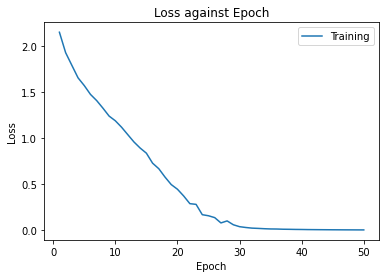

Test Accuracy of the model: 100.00 %
done for k=24; n=2048
Epoch: 1 	Training Loss: 2.149887
Epoch: 2 	Training Loss: 1.908216
Epoch: 3 	Training Loss: 1.738763
Epoch: 4 	Training Loss: 1.618868
Epoch: 5 	Training Loss: 1.531316
Epoch: 6 	Training Loss: 1.460169
Epoch: 7 	Training Loss: 1.356237
Epoch: 8 	Training Loss: 1.286108
Epoch: 9 	Training Loss: 1.221399
Epoch: 10 	Training Loss: 1.159591
Epoch: 11 	Training Loss: 1.085682
Epoch: 12 	Training Loss: 1.039458
Epoch: 13 	Training Loss: 0.977606
Epoch: 14 	Training Loss: 0.912808
Epoch: 15 	Training Loss: 0.851878
Epoch: 16 	Training Loss: 0.781788
Epoch: 17 	Training Loss: 0.750768
Epoch: 18 	Training Loss: 0.666358
Epoch: 19 	Training Loss: 0.615887
Epoch: 20 	Training Loss: 0.580937
Epoch: 21 	Training Loss: 0.487574
Epoch: 22 	Training Loss: 0.462216
Epoch: 23 	Training Loss: 0.375579
Epoch: 24 	Training Loss: 0.344652
Epoch: 25 	Training Loss: 0.282450
Epoch: 26 	Training Loss: 0.255671
Epoch: 27 	Training Loss: 0.199032
Epoch

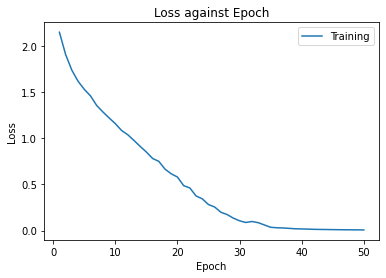

Test Accuracy of the model: 100.00 %
done for k=48; n=128
Epoch: 1 	Training Loss: 2.201063
Epoch: 2 	Training Loss: 1.985407
Epoch: 3 	Training Loss: 1.811261
Epoch: 4 	Training Loss: 1.708084
Epoch: 5 	Training Loss: 1.588766
Epoch: 6 	Training Loss: 1.504927
Epoch: 7 	Training Loss: 1.412804
Epoch: 8 	Training Loss: 1.351693
Epoch: 9 	Training Loss: 1.291769
Epoch: 10 	Training Loss: 1.195906
Epoch: 11 	Training Loss: 1.129904
Epoch: 12 	Training Loss: 1.073171
Epoch: 13 	Training Loss: 1.004131
Epoch: 14 	Training Loss: 0.938393
Epoch: 15 	Training Loss: 0.877466
Epoch: 16 	Training Loss: 0.804218
Epoch: 17 	Training Loss: 0.741571
Epoch: 18 	Training Loss: 0.669517
Epoch: 19 	Training Loss: 0.623300
Epoch: 20 	Training Loss: 0.546039
Epoch: 21 	Training Loss: 0.492687
Epoch: 22 	Training Loss: 0.428930
Epoch: 23 	Training Loss: 0.364765
Epoch: 24 	Training Loss: 0.325281
Epoch: 25 	Training Loss: 0.279010
Epoch: 26 	Training Loss: 0.232314
Epoch: 27 	Training Loss: 0.182904
Epoch:

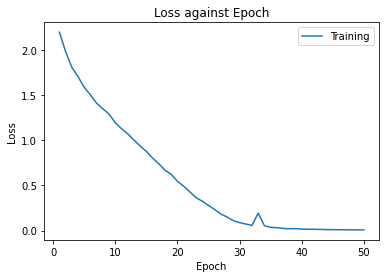

Test Accuracy of the model: 99.98 %
done for k=48; n=256
Epoch: 1 	Training Loss: 2.133631
Epoch: 2 	Training Loss: 1.890284
Epoch: 3 	Training Loss: 1.734414
Epoch: 4 	Training Loss: 1.611897
Epoch: 5 	Training Loss: 1.501265
Epoch: 6 	Training Loss: 1.434393
Epoch: 7 	Training Loss: 1.334683
Epoch: 8 	Training Loss: 1.283783
Epoch: 9 	Training Loss: 1.194659
Epoch: 10 	Training Loss: 1.124986
Epoch: 11 	Training Loss: 1.065063
Epoch: 12 	Training Loss: 0.995576
Epoch: 13 	Training Loss: 0.925252
Epoch: 14 	Training Loss: 0.883664
Epoch: 15 	Training Loss: 0.775242
Epoch: 16 	Training Loss: 0.712716
Epoch: 17 	Training Loss: 0.640293
Epoch: 18 	Training Loss: 0.582676
Epoch: 19 	Training Loss: 0.507649
Epoch: 20 	Training Loss: 0.434675
Epoch: 21 	Training Loss: 0.365847
Epoch: 22 	Training Loss: 0.314984
Epoch: 23 	Training Loss: 0.272132
Epoch: 24 	Training Loss: 0.222000
Epoch: 25 	Training Loss: 0.173522
Epoch: 26 	Training Loss: 0.136720
Epoch: 27 	Training Loss: 0.094056
Epoch: 

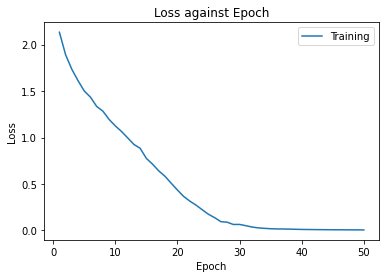

Test Accuracy of the model: 100.00 %
done for k=48; n=512
Epoch: 1 	Training Loss: 2.186331
Epoch: 2 	Training Loss: 1.934766
Epoch: 3 	Training Loss: 1.766829
Epoch: 4 	Training Loss: 1.643181
Epoch: 5 	Training Loss: 1.528802
Epoch: 6 	Training Loss: 1.439585
Epoch: 7 	Training Loss: 1.380641
Epoch: 8 	Training Loss: 1.298618
Epoch: 9 	Training Loss: 1.213498
Epoch: 10 	Training Loss: 1.144084
Epoch: 11 	Training Loss: 1.076101
Epoch: 12 	Training Loss: 1.006172
Epoch: 13 	Training Loss: 0.922824


In [ ]:
#Create, train and test variants of CNN
CNNs={}
accuracy={}
for k in [3,6,12,24,48]:
    CNNs[k]={}
    accuracy[k]={}
    for n in [128, 256, 512, 1024, 2048]:
        CNNs[k][n]=CNN_variant(k, n)
        train(CNNs[k][n], learning_rate=0.1)
        accuracy[k][n]=test(CNNs[k][n])
        print('done for k='+str(k)+'; n='+str(n))

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} tabulate

In [ ]:
#Print in tabular format for accuracy in testing data
rows=[]
count=0
for n in [128, 256, 512, 1024, 2048]:
    rows.append(['n='+str(n)])
    for k in [3,6,12,24,48]:
        rows[count].append("{:.2f}".format(accuracy[k][n]*100)+'%')
    count += 1
        
print('CNN variant accuracy in testing data')
from tabulate import tabulate
print(tabulate(rows, headers=['Accuracy', 'k=3', 'k=6','k=12','k=24','k=48']))


# Tuning Learning Rate
The first success of achieving accuracy over 99% is done by increasing learning rate (from 0.005 to 0.1) of the first tried CNN model, as it was observed learning too slowly and the accuracy was too low, and based on my analogy with Newton's Method of converging numerical solutions (where "learning rate" is simply 1). Hence, it must have great impact to the accuracry and performance within a limited number of epochs (50 in our case). As we already achieve 100% accuracy, we will focus more on model simplicity (a.k.a. fewer parameters) by tuning learning rate and won't bother with regularization tuning. Hoping to speed up convergence to improve from 99% accuracy to 100%, we try only higher learning rate.

In [ ]:
for k, n in [[3,128],[6,128],[12,128],[3,256],[6,256],[12,256],[3,512],[6,512],[3,1024]]:
    CNNs[k][n]=CNN_variant(k, n)
    train(CNNs[k][n], learning_rate=0.2, visible=False)
    print('k='+str(k)+', n='+str(n)+' -- ', end='')
    test(CNNs[k][n])

# Conclusion

If we approximate the number of parameters by ignoring bias term, we can have the following formula:
no. of parameters ~= 9k + 256kn +10n

By minimizing the formula, we have (k=3, n=128)  or (k=6, n=128) as the simplest 2 models.

Before we conclude, let's test the robustness against randomness, and use a training function that enables us to see validation loss as well.


In [ ]:
seed=1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
CNNs[3][128]=CNN_variant(3, 128)
train_val(CNNs[3][128], learning_rate=0.2)
test(CNNs[3][128])

In [ ]:
seed=1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
CNNs[6][128]=CNN_variant(6, 128)
train_val(CNNs[6][128], learning_rate=0.2)
test(CNNs[6][128])

In [ ]:
seed=2
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
CNNs[6][128]=CNN_variant(6, 128)
train_val(CNNs[6][128], learning_rate=0.2)
test(CNNs[6][128])

So, (k=3, n=128) can be ruled out.

Although (k=6, n=128) doesn't get 100% accuracy in all random states above, we can't guarantee 100% accuracy of other models in all random states either. And 99.91% still looks very good. And there is a possibilty that it may converge further given more epochs.

So among above trials, the simplest model that has got 99.9%-100% accuracy is (k=6, n=128), i.e.
1 convolutional layer (6 channels, kernels size 3, stride 1, padding 1, with MaxPool(2,2) then RELU), followed by 1 hidden fully connected layer (128 nodes, RELU) and 1 output layer (10 classes), at learning rate = 0.2 using Pytorch SGD optimizer with batch size 100, 50 epochs and cross-entropy loss function.

Disclaimer: we cannot guarantee it has 99.9%-100% accuracy in every random state, though we have tested multiple random states for initialization of weights and training. But at least we have proved that there exists some sets of weights for such simple CNN model to acheive extremely high (if not prefect) accuracy.

Note: learning rate of 0.2 may cause some other variant models to deteriorate sharply in accuracy in certain random states. This may also imply possibly there are local optima for similar variant models in this application.

Let's save the final model.

In [ ]:
torch.save(CNNs[6][128].state_dict(), './cifar_CNN_final.pth')

### Others
For the chosen model, the validation loss curve is consistently slightly lower than training loss for most of the time, possibly due to combination of two reasons:
1) the model learns so well that it doesn't over-fit and
2) the validation loss is calculated in model.eval, after the model.train mode, so it always uses parameters more recently updated (one mini-batch ahead of those calculating training loss).

### Reference
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://cs231n.github.io/convolutional-networks/

https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module